# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=";")


In [3]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(f'{azdias.info()}')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [5]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. 

Convert data that matches a 'missing' or 'unknown' value code into a **numpy NaN** value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
mou = feat_info['missing_or_unknown']
def split_string(str):
    "Rerturns a list of strings"
    return str[1:-1].split(",")

def to_int(str):
    if str.lstrip('-').isdigit():
        return int(str)
    return str

def string_to_list(li):
    return list(map(to_int, li))

def convert_missing(str):
    list_of_values = split_string(str)
    rtn = string_to_list(list_of_values)
    print(f'{rtn}')
    return rtn

# for elm in range(0,len(mou)):
#     con = convert_missing(mou[elm])
#     print(f'{con}')
    

In [8]:
# convert missing or unknows to array
converted_mou = feat_info['missing_or_unknown'].transform(lambda str: convert_missing(str))
feat_info['missing_or_unknown'] = converted_mou

[-1, 0]
[-1, 0, 9]
[-1, 0]
[0]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[0]
['']
['']
[-1, 0]
[0]
[0]
[0]
[0]
[0]
[0]
[-1, 0]
[-1, 0]
[0]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1]
[-1]
[-1, 0]
[-1]
[-1, 9]
[0]
['']
['']
[-1, 0]
[-1]
[-1, 0]
[-1, 0]
[0]
['']
[-1, 0]
['']
[0]
[-1]
[-1]
[-1, 'X']
['XX']
[-1, 'XX']
[-1]
[-1]
[-1]
[-1]
[-1, 0]
[-1, 0]
[-1]
[-1]
[-1]
['']
[-1, 0]
['']
['']
[-1, 0]
['']
[-1]
[-1]
[-1]
[-1]
[-1, 0]
[-1]
[-1]
[-1, 9]
[-1, 0]
[-1, 9]


In [9]:
feat_info['missing_or_unknown'][57]

[-1, 'X']

In [10]:
'X' in feat_info['missing_or_unknown'][57]

True

In [11]:
-1 in feat_info['missing_or_unknown'][57]

True

In [12]:
feat_info['missing_or_unknown'][0]

[-1, 0]

In [13]:
# Identify missing or unknown data values and convert them to NaNs
for i in range(0, azdias.shape[1]):
    azdias.iloc[:,i].replace(feat_info['missing_or_unknown'][i],np.nan, inplace=True)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? 

There are a few columns that are outliers in terms of the proportion of values that are missing. 

**Identify and document these columns.**

While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just **remove them from the dataframe**. 

~~You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns.~~

You will want to use [`Series.plot()`](https://pandas.pydata.org/pandas-docs/stable/reference/series.html#plotting)

(Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, **are there any patterns in which columns have, or share, missing data?**

In [14]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

na_series = azdias.isna().sum()
na_series.head()


AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
dtype: int64

In [15]:
total_missing = na_series.sum()
total_missing

8373929

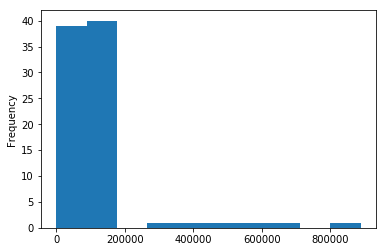

In [16]:
na_series.plot.hist()

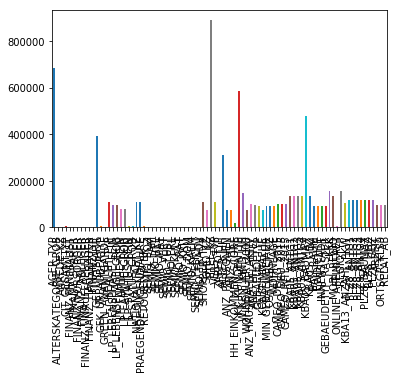

In [17]:
na_series.plot.bar()

In [18]:
# Investigate patterns in the amount of missing data in each column.
n_largest = na_series.nlargest(10)
n_largest

TITEL_KZ          889061
AGER_TYP          685843
KK_KUNDENTYP      584612
KBA05_BAUMAX      476524
GEBURTSJAHR       392318
ALTER_HH          310267
KKK               158064
REGIOTYP          158064
W_KEIT_KIND_HH    147988
KBA05_ANTG1       133324
dtype: int64

In [19]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#####################################################
## DROPPING 2 COLUMNS WITH THE MOST MISSING VALUES ## 
#####################################################

azdias.drop(columns=n_largest[0:2].index, inplace=True)


In [20]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


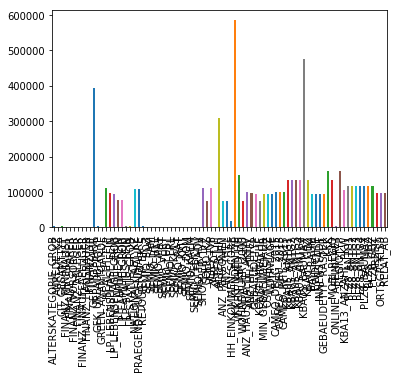

In [21]:
na_series = azdias.isna().sum()
na_series.plot.bar()

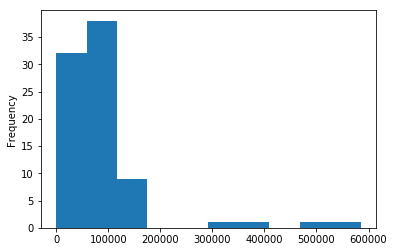

In [22]:
na_series.plot.hist()

In [23]:
na_series.mean()

81915.96385542168

In [24]:
na_series[na_series > 100000].shape

(26,)

In [25]:
na_series[na_series > 50000].shape

(51,)

In [26]:
na_series[na_series < 50000].shape

(32,)

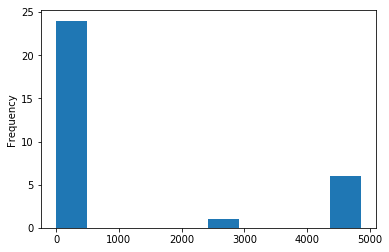

In [27]:
na_series[na_series < 10000].plot.hist()

In [28]:
na_series[na_series < 10000]

ALTERSKATEGORIE_GROB     2881
ANREDE_KZ                   0
CJT_GESAMTTYP            4854
FINANZ_MINIMALIST           0
FINANZ_SPARER               0
FINANZ_VORSORGER            0
FINANZ_ANLEGER              0
FINANZ_UNAUFFAELLIGER       0
FINANZ_HAUSBAUER            0
FINANZTYP                   0
GFK_URLAUBERTYP          4854
GREEN_AVANTGARDE            0
LP_STATUS_FEIN           4854
LP_STATUS_GROB           4854
RETOURTYP_BK_S           4854
SEMIO_SOZ                   0
SEMIO_FAM                   0
SEMIO_REL                   0
SEMIO_MAT                   0
SEMIO_VERT                  0
SEMIO_LUST                  0
SEMIO_ERL                   0
SEMIO_KULT                  0
SEMIO_RAT                   0
SEMIO_KRIT                  0
SEMIO_DOM                   0
SEMIO_KAEM                  0
SEMIO_PFLICHT               0
SEMIO_TRADV                 0
ZABEOTYP                    0
ONLINE_AFFINITAET        4854
dtype: int64

In [29]:
na_series[na_series == 0].shape

(24,)

In [30]:
na_series[na_series == 4854]

CJT_GESAMTTYP        4854
GFK_URLAUBERTYP      4854
LP_STATUS_FEIN       4854
LP_STATUS_GROB       4854
RETOURTYP_BK_S       4854
ONLINE_AFFINITAET    4854
dtype: int64

In [31]:
na_series.nlargest(5)

KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
GEBURTSJAHR     392318
ALTER_HH        310267
KKK             158064
dtype: int64

In [32]:
na_series[na_series.between(1, 99611)].shape

(33,)

In [33]:
na_series[na_series.between(99612, 5000000)].sort_values()

KBA13_ANZAHL_PKW         105800
PRAEGENDE_JUGENDJAHRE    108164
NATIONALITAET_KZ         108315
HEALTH_TYP               111196
SHOPPER_TYP              111196
VERS_TYP                 111196
PLZ8_GBZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
PLZ8_ANTG1               116515
PLZ8_HHZ                 116515
MOBI_REGIO               133324
KBA05_ANTG4              133324
KBA05_ANTG3              133324
KBA05_ANTG2              133324
KBA05_ANTG1              133324
KBA05_GBZ                133324
W_KEIT_KIND_HH           147988
KKK                      158064
REGIOTYP                 158064
ALTER_HH                 310267
GEBURTSJAHR              392318
KBA05_BAUMAX             476524
KK_KUNDENTYP             584612
dtype: int64

In [34]:
na_series[na_series.between(99612, 5000000)].sort_values().shape

(26,)

#### Discussion 1.1.2: Assess Missing Data in Each Column

##### Which columns were removed from the dataset?
The two columns that were dropped are `TITEL_KZ` with `889061` and `AGER_TYP` with `685843` missing values, respectivly.

This leaves us with 82 columns.

##### Observations and Patterns

After having removed the two columns with the most missing values:

* 24 columns have 0 missing values.
* 33 columns are in the interval from 2881 to 99611 missing values
* 22 cloumns have between and 105800 and 158064
* The top four columns have between 310267 and 584612 missing values
   
The top four columns have considerably more missing errors than the middle interval: 


| COLUMN      | N MISSING |
|-------------|:---------:|
|ALTER_HH     | 310267    |
|GEBURTSJAHR  | 392318    |
|KBA05_BAUMAX | 476524    |
|KK_KUNDENTYP | 584612    |


There's a gap in numbers of missing values from 0 up to 4854.

There is 6 columns with excatly 4854 missing values. This makes me think that there might be some systemic flaw in the data collection.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. 

How much data is missing in each row? 

As with the columns, you should see some groups of points that have a very different numbers of missing values. 

**Divide the data into two subsets: one for data points that are above some `threshold` for missing values, and a second subset for points below that threshold.**

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. 

**Select at least five of these columns and compare the distribution of values.**

- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [35]:
# How much data is missing in each row of the dataset?
na_rows = azdias.isna().sum(axis=1)
na_rows

0         47
1          2
2          2
3          8
4          1
5          1
6          3
7          2
8          2
9          1
10         1
11        51
12         8
13         9
14        51
15        10
16         7
17        51
18         7
19         3
20        14
21         4
22         4
23         9
24        51
25         7
26        22
27         3
28         2
29         3
          ..
891191     0
891192     2
891193     1
891194     0
891195     1
891196     0
891197     0
891198     2
891199     3
891200     3
891201     1
891202     3
891203    18
891204     0
891205     2
891206     1
891207     1
891208     4
891209     3
891210     2
891211     2
891212     2
891213     1
891214     2
891215     3
891216     4
891217     5
891218     7
891219     3
891220     4
Length: 891221, dtype: int64

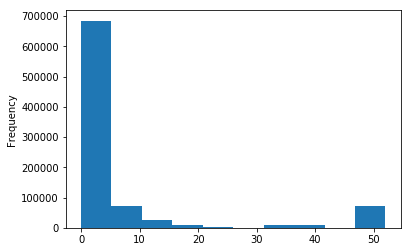

In [36]:
na_rows.plot.hist()

In [37]:
na_rows.nlargest(10)

732775    52
11        51
14        51
17        51
24        51
48        51
54        51
69        51
75        51
97        51
dtype: int64

In [38]:
# Write code to divide the data into two subsets 
# based on the number of missing values in each row.

def split_data_on_nans(dataframe, threshold):
    """
    Takes a DataFrame, counts the NaNs in each row.
    Then appends the column `n_nans` containing the number of NaNs for each row.
    
    Then splits the DataFrame into two frames. One where the number of NaNs is
    lesser than or equal to `threshold` and one where it's greater than `threshold`
    
    returns a tuple with the two new DataFrames: `(lesser_than_or_eq, greater_than)`
    """
    n_nans = dataframe.isna().sum(axis=1)
    dataframe['n_nans'] = n_nans
    sorted_values = dataframe.sort_values(by=['n_nans'])
    low = sorted_values[sorted_values['n_nans'] <= threshold]
    high = sorted_values[sorted_values['n_nans'] > threshold]
    return (low, high)

In [39]:
##########################
# SPLITTING ON N MISSING #
##########################
low, high = split_data_on_nans(azdias, 10)

In [40]:
low.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,n_nans
445610,4.0,2,2.0,5,1,5,2,1,3,2,...,1.0,0.0,0.0,1.0,4.0,5.0,2.0,1.0,1.0,0
340391,4.0,2,4.0,3,3,2,3,5,1,3,...,3.0,2.0,1.0,1.0,4.0,4.0,4.0,8.0,5.0,0
340392,4.0,1,3.0,4,4,4,4,1,1,6,...,2.0,0.0,0.0,1.0,3.0,4.0,3.0,2.0,3.0,0
116034,4.0,1,1.0,3,1,5,1,1,5,6,...,4.0,3.0,2.0,4.0,4.0,2.0,3.0,5.0,2.0,0
340398,4.0,1,4.0,4,4,2,4,4,2,3,...,2.0,1.0,0.0,1.0,4.0,5.0,2.0,2.0,2.0,0


In [41]:
low.tail()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,n_nans
75766,3.0,2,4.0,3,2,4,3,1,3,6,...,3.0,2.0,1.0,1.0,3.0,3.0,3.0,5.0,1.0,10
722696,3.0,2,2.0,4,2,3,4,2,2,6,...,2.0,0.0,0.0,1.0,2.0,3.0,4.0,3.0,4.0,10
179822,3.0,2,6.0,1,5,2,4,4,5,1,...,3.0,2.0,2.0,5.0,5.0,3.0,4.0,9.0,3.0,10
488386,1.0,2,NaN,1,5,3,5,4,5,1,...,4.0,3.0,2.0,5.0,3.0,1.0,4.0,9.0,3.0,10
43329,4.0,2,5.0,5,1,5,2,3,2,2,...,2.0,0.0,0.0,1.0,2.0,3.0,3.0,1.0,4.0,10


In [42]:
high.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,n_nans
704180,3.0,1,5.0,2,5,3,5,4,3,1,...,1.0,0.0,0.0,1.0,2.0,2.0,3.0,2.0,3.0,11
843396,1.0,1,3.0,1,3,3,5,5,4,1,...,2.0,2.0,1.0,1.0,5.0,4.0,4.0,6.0,3.0,11
138484,3.0,1,5.0,1,5,2,5,5,5,1,...,3.0,1.0,0.0,1.0,3.0,3.0,4.0,5.0,3.0,11
776343,3.0,2,5.0,1,5,3,4,4,5,1,...,3.0,2.0,2.0,5.0,3.0,2.0,3.0,6.0,2.0,11
475450,3.0,2,5.0,1,5,3,5,4,5,1,...,4.0,3.0,1.0,3.0,4.0,3.0,5.0,8.0,5.0,11


In [43]:
high.tail()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,n_nans
743520,2.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51
743518,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51
330796,1.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51
307460,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51
732775,3.0,2,NaN,3,5,3,5,5,2,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52


**Divide the data into two subsets**: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data are similar or different between the two groups.

**Select at least five of these columns and compare the distribution of values.**

You can use seaborn's countplot() function to create a bar chart of code frequencies and matplotlib's subplot() function to put bar charts for the two subplots side by side.

In [44]:
five_na_columns = list(na_series.sort_values().iloc[0:5].index)
five_na_columns

['SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL']

In [45]:
def draw_count_plot(category_name):
    f, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 6))
    sns.countplot(x=category_name, data=low, ax=axes[0])
    sns.countplot(x=category_name, data=high, ax=axes[1])
    axes[0].set(xlabel="LOW: count")
    axes[1].set(xlabel="HIGH: count")

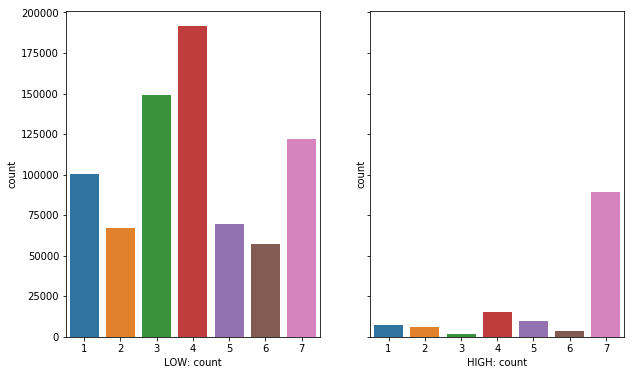

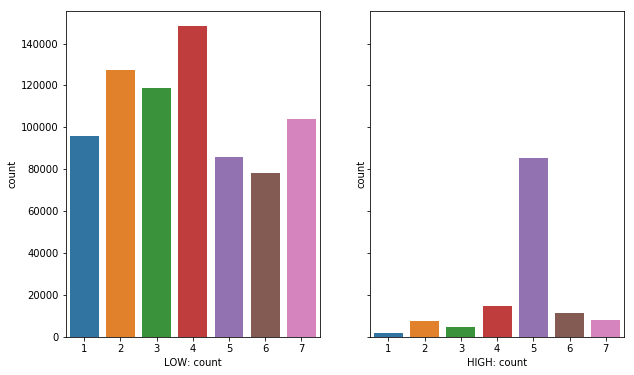

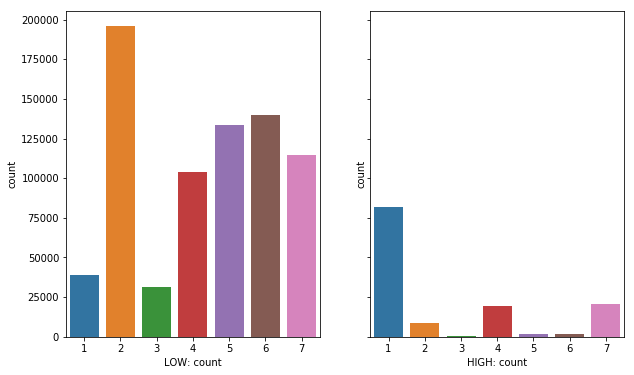

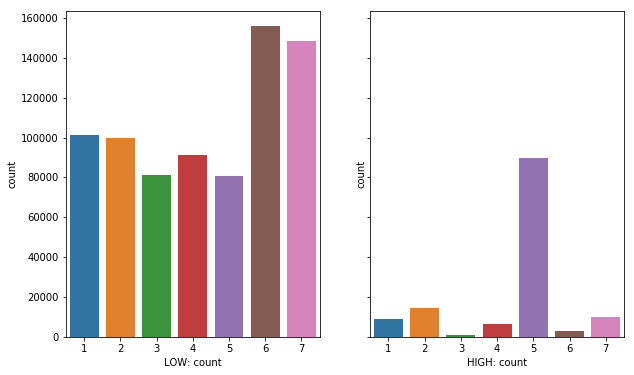

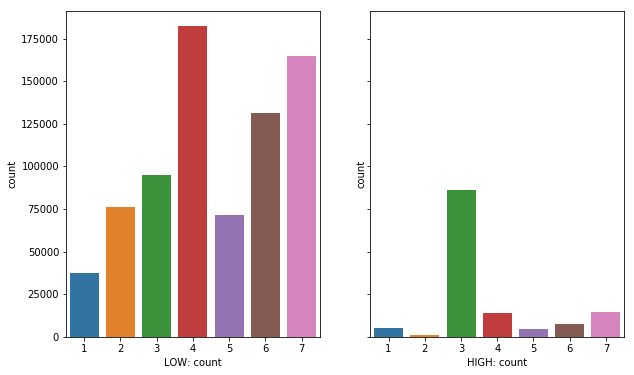

In [46]:
for name in five_na_columns:
    draw_count_plot(name)

#### Discussion 1.1.3: Assess Missing Data in Each Row

##### Are the data with lots of missing values qualitatively different from data with few or no missing values?

The data with lots of missing data generaly have one value that is over represented. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will:
* Perform an investigation of the categorical and mixed-type features and make a decision on each of them, **whether you will keep, drop, or re-encode each**. 
* Then, in the last part, you will **create a new data frame with only the selected and engineered columns.**

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

# ONLY USE `LOW` FROM HERE

In [47]:
# How many features are there of each data type?
feat_info.groupby("type").count()["attribute"]

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: attribute, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [48]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_info = feat_info[feat_info["type"] == "categorical"]
print(f'{categorical_info.shape[0]} categorical attributes')

categorical_info


21 categorical attributes


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


In [49]:
categories = list(categorical_info["attribute"])

categories

['AGER_TYP',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'TITEL_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'KK_KUNDENTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [50]:
# Remove the categories that are no longer in the dataset
for cat in categories:
    if cat not in list(low.iloc[0,:].index):
        categories.remove(cat)
        
categories

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'KK_KUNDENTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [51]:
# The categorical attributes I have deemed relevant
relevant_attributes = [
    'ANREDE_KZ',
    'CJT_GESAMTTYP',
    'FINANZTYP',
    'GFK_URLAUBERTYP',
    'GREEN_AVANTGARDE',
    'LP_FAMILIE_FEIN',
    'LP_STATUS_FEIN',
    'SHOPPER_TYP',
    'ZABEOTYP',
    'KK_KUNDENTYP',
    'CAMEO_DEUG_2015',
    'CAMEO_DEU_2015'
]

In [52]:
def diff_list(li1, li2): 
    li_diff = [i for i in li1 + li2 if i not in li1 or i not in li2] 
    return li_diff

In [53]:

# DROP IRRELEVANT ATTRIBUTES

irrelevant_attributes = diff_list(categories, relevant_attributes)
irrelevant_attributes

['LP_FAMILIE_GROB',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SOHO_KZ',
 'VERS_TYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ']

In [54]:
low.drop(irrelevant_attributes, axis=1, inplace=True)

In [55]:
# Get the columns that are "categorical"
categorical_data = low.loc[:, relevant_attributes]

In [56]:
categorical_data.head()

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_STATUS_FEIN,SHOPPER_TYP,ZABEOTYP,KK_KUNDENTYP,CAMEO_DEUG_2015,CAMEO_DEU_2015
445610,2,2.0,2,7.0,0,2.0,7.0,1.0,3,6.0,2,2B
340391,2,4.0,3,1.0,1,1.0,8.0,3.0,4,5.0,1,1B
340392,1,3.0,6,5.0,0,11.0,9.0,0.0,3,2.0,6,6B
116034,1,1.0,6,4.0,0,1.0,1.0,3.0,3,4.0,8,8D
340398,1,4.0,3,1.0,0,11.0,9.0,3.0,4,4.0,3,3C


In [57]:
category_dict = {}

# get the types of values the categories have
for col in categorical_data:
    values = list(categorical_data[col].value_counts().keys())
    category_dict[col] = values

category_dict

{'ANREDE_KZ': [2, 1],
 'CJT_GESAMTTYP': [4.0, 3.0, 2.0, 5.0, 6.0, 1.0],
 'FINANZTYP': [6, 1, 5, 2, 4, 3],
 'GFK_URLAUBERTYP': [12.0,
  10.0,
  8.0,
  11.0,
  5.0,
  4.0,
  9.0,
  3.0,
  1.0,
  7.0,
  2.0,
  6.0],
 'GREEN_AVANTGARDE': [0, 1],
 'LP_FAMILIE_FEIN': [1.0, 10.0, 2.0, 11.0, 8.0, 7.0, 4.0, 5.0, 9.0, 6.0, 3.0],
 'LP_STATUS_FEIN': [1.0, 9.0, 10.0, 2.0, 4.0, 3.0, 6.0, 5.0, 8.0, 7.0],
 'SHOPPER_TYP': [1.0, 2.0, 3.0, 0.0],
 'ZABEOTYP': [3, 4, 1, 5, 6, 2],
 'KK_KUNDENTYP': [3.0, 2.0, 5.0, 4.0, 6.0, 1.0],
 'CAMEO_DEUG_2015': ['8', '9', '6', '4', '3', '2', '7', '5', '1'],
 'CAMEO_DEU_2015': ['6B',
  '8A',
  '4C',
  '2D',
  '3C',
  '7A',
  '3D',
  '8B',
  '4A',
  '8C',
  '9D',
  '9B',
  '9C',
  '7B',
  '9A',
  '2C',
  '8D',
  '6E',
  '2B',
  '5D',
  '6C',
  '2A',
  '1D',
  '5A',
  '1A',
  '5B',
  '5C',
  '7C',
  '4B',
  '4D',
  '3A',
  '3B',
  '6A',
  '6D',
  '9E',
  '6F',
  '4E',
  '7D',
  '1E',
  '7E',
  '1C',
  '5F',
  '1B',
  '5E']}

In [58]:
non_binary_attributes = list(filter(lambda elm: len(elm[1]) != 2, category_dict.items()))
non_binary_attributes = list(map(lambda tup: tup[0], non_binary_attributes))

In [59]:
non_binary_attributes

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_STATUS_FEIN',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'KK_KUNDENTYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [60]:
# Re-encode categorical variable(s) to be kept in the analysis.

low = pd.get_dummies(azdias, columns=non_binary_attributes)

In [61]:
low.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,2.0,1,3,4,3,5,5,3,NaN,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2,1,5,2,5,4,5,1996.0,0,...,0,1,0,0,0,0,0,0,0,0
2,3.0,2,1,4,1,2,3,5,1979.0,1,...,0,0,0,0,0,0,0,0,0,0
3,4.0,2,4,2,5,2,1,2,1957.0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,1963.0,0,...,0,0,0,0,0,0,0,0,0,0


# Discussion 1.2.1: Re-Encode Categorical Features

##### Findings and decisions regarding categorical features. 

**Kept:**

I deemed the following attributes directly relevant for buying power and interests:

```
relevant_attributes = [
    'ANREDE_KZ',
    'CJT_GESAMTTYP',
    'FINANZTYP',
    'GFK_URLAUBERTYP',
    'GREEN_AVANTGARDE',
    'LP_FAMILIE_FEIN',
    'LP_STATUS_FEIN',
    'SHOPPER_TYP',
    'ZABEOTYP',
    'KK_KUNDENTYP',
    'CAMEO_DEUG_2015',
    'CAMEO_DEU_2015'
]
```
**Encoded:** 
Of the `relevant_attributes` I encoded the non-binary attributes:

```
['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_STATUS_FEIN',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'KK_KUNDENTYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']
```

**Dropped:** 

The categorical attributes not in `relevant_attributes` was dropped, namely: 

```
['LP_FAMILIE_GROB',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SOHO_KZ',
 'VERS_TYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ']
 ```

# Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [62]:
# GET MIXED CATEGORIES
mixed_info = feat_info[feat_info["type"] == "mixed"]

In [63]:
mixed_info

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1, 0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1, 0]"


In [64]:
mixed_attributes = list(mixed_info["attribute"])

mixed_attributes

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

In [65]:
# Make sure I haven't dropped any already
for attr in mixed_attributes:
    if attr not in list(low.loc[0,:].index):
        mixed_attributes.remove(attr)

In [66]:
mixed_attributes

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

In [67]:
# The mixed attributes I've deemed relevant,
relavant_mixed_attributes = [
    'WOHNLAGE',
    'PRAEGENDE_JUGENDJAHRE',
    'CAMEO_INTL_2015'
]

In [68]:
# Get "mixed" data
mixed_data = low.loc[:, relavant_mixed_attributes]

In [69]:
mixed_dict = {}

# get the types of values the categories have
for col in mixed_data:
    values = list(mixed_data[col].value_counts().keys())
    mixed_dict[col] = values


In [70]:
mixed_dict

{'WOHNLAGE': [3.0, 7.0, 4.0, 2.0, 5.0, 1.0, 8.0, 0.0],
 'PRAEGENDE_JUGENDJAHRE': [14.0,
  8.0,
  5.0,
  10.0,
  3.0,
  15.0,
  11.0,
  9.0,
  6.0,
  12.0,
  1.0,
  4.0,
  2.0,
  13.0,
  7.0],
 'CAMEO_INTL_2015': ['51',
  '41',
  '24',
  '14',
  '43',
  '54',
  '25',
  '22',
  '23',
  '13',
  '45',
  '55',
  '52',
  '31',
  '34',
  '15',
  '44',
  '12',
  '35',
  '32',
  '33']}

In [71]:
irrelevant_mixed_attributes = diff_list(mixed_attributes, relavant_mixed_attributes)

In [72]:
irrelevant_mixed_attributes

['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']

### Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

"PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.

- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

#### `PRAEGENDE_JUGENDJAHRE_MOVEMENT`
```
0: "Mainstream"
1: "Avantgarde"
```

#### `PRAEGENDE_JUGENDJAHRE_DECADE`
> generation by decade

```
1: 40s
2: 50s
3: 60s
4: 70s
5: 80s
6: 90s
```

In [73]:
# 0 for Mainstream and 1 for Avantgarde
pj_dict = {
    np.nan: (np.nan, np.nan),
    1: (1, 0),
    2: (1, 1),
    3:(2,  0),
    4:(2,  1),
    5:(3,  0),
    6:(3,  1),
    7:(3,  1),
    8:(4,  0),
    9:(4,  1),
    10:(5, 0),
    11:(5, 1),
    12:(5, 0),
    13:(5, 1),
    14:(6, 0),
    15:(6, 1)
}

In [74]:
pj = low.loc[:,"PRAEGENDE_JUGENDJAHRE"].copy()

In [75]:
new_s = pj.map(pj_dict)

In [76]:
new_pj_columns = pd.DataFrame(new_s.tolist(), columns=["PRAEGENDE_JUGENDJAHRE_DECADE", "PRAEGENDE_JUGENDJAHRE_MOVEMENT"], index=new_s.index)

In [77]:
low["PRAEGENDE_JUGENDJAHRE_DECADE"] = new_pj_columns["PRAEGENDE_JUGENDJAHRE_DECADE"]

In [78]:
low["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = new_pj_columns["PRAEGENDE_JUGENDJAHRE_MOVEMENT"]

In [79]:
## DROP THE ORIGINAL "PRAEGENDE_JUGENDJAHRE_DECADE"

low.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [80]:
# Drop irrelevant mixed attributes
low.drop(irrelevant_mixed_attributes, axis=1, inplace=True)

**"CAMEO_INTL_2015"** combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

#### `CAMEO_INTEL_2015_WEALTH`
```
1: Wealthy Households
2: Prosperous Households
3: Comfortable Households
4: Less Affluent Households
5: Poorer Households
```

#### `CAMEO_INTEL_2015_LIFE_STAGE`

```
1: Pre-Family Couples & Singles
2: Pre-Family Couples & Singles
3: Families With School Age Children
4: Older Families &  Mature Couples
5: Older Families &  Mature Couples
```

In [81]:
ci2015 = low.loc[:, 'CAMEO_INTL_2015'].copy()

In [82]:
# Get CAMEO_2015_WEALTH values
cameo_split = ci2015.str.extract(r'^(\d)(\d)$')

In [83]:
new_cameo_cols = {
    0:'CAMEO_INTEL_2015_WEALTH',
    1:'CAMEO_INTEL_2015_LIFE_STAGE'
}
cameo_split = cameo_split.rename(columns=new_cameo_cols)

In [84]:
# APPEND NEW CAMEO COLUMNS to `low`

low['CAMEO_INTEL_2015_WEALTH'] = cameo_split['CAMEO_INTEL_2015_WEALTH']
low['CAMEO_INTEL_2015_LIFE_STAGE'] = cameo_split['CAMEO_INTEL_2015_LIFE_STAGE']

In [85]:
# DROP `CAMEO_INTL_2015`
low.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [86]:
# Cast new attributes to ints
low.CAMEO_INTEL_2015_WEALTH = pd.to_numeric(low.CAMEO_INTEL_2015_WEALTH, errors='coerce')


In [87]:
low.CAMEO_INTEL_2015_LIFE_STAGE = pd.to_numeric(low.CAMEO_INTEL_2015_LIFE_STAGE, errors='coerce')

## Discussion 1.2.2: Engineer Mixed-Type Features

##### Findings and decisions regarding mixed-value features. 

###### Engineered Attributes

**PRAEGENDE_JUGENDJAHRE**
`PRAEGENDE_JUGENDJAHRE` was mapped into two new attributes. `PRAEGENDE_JUGENDJAHRE_DECADE` for the generation divided in decades in the interval `1940-1990` and another `PRAEGENDE_JUGENDJAHRE_MOVEMENT` for the association of one of the movements "Mainstream" and "Avantgarde".

The mapping is as follows:

`PRAEGENDE_JUGENDJAHRE_MOVEMENT`

> Movement association

```
0: "Mainstream"
1: "Avantgarde"
```

`PRAEGENDE_JUGENDJAHRE_DECADE`

> Generation by decade

```
1: 40s
2: 50s
3: 60s
4: 70s
5: 80s
6: 90s
```

**CAMEO_INTEL_2015**
`CAMEO_INTEL_2015` had two dimensions, respectivly represented by the first and second digit in a two digit number. This number was represented as a string. It was split into two attributes (`CAMEO_INTEL_2015_WEALTH` and `CAMEO_INTEL_2015_LIFE_STAGE`) using the pandas function `Series.str.extract()`. 

The mapping is as follows:

`CAMEO_INTEL_2015_WEALTH`

> Household wealth by category

```
1: Wealthy Households
2: Prosperous Households
3: Comfortable Households
4: Less Affluent Households
5: Poorer Households
```

`CAMEO_INTEL_2015_LIFE_STAGE`

> Life stage by category

```
1: Pre-Family Couples & Singles
2: Pre-Family Couples & Singles
3: Families With School Age Children
4: Older Families &  Mature Couples
5: Older Families &  Mature Couples
```

###### Kept values

Besides the engineered attributes I kept `WOHNLAGE` which describes "Neighborhood quality (or rural flag)"

###### Dropped values

I dropped the following attributes because they cover much of the same as the engineered attributes and `WOHNLAGE`. Also to keep the number of dummy attributes down.

```
LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
PRAEGENDE_JUGENDJAHRE
CAMEO_INTL_2015
KBA05_BAUMAX
PLZ8_BAUMAX
```

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [88]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
black_list = [
    'CAMEO_INTEL_2015',
    'PRAEGENDE_JUGENDJAHRE'
] + irrelevant_attributes + irrelevant_mixed_attributes


In [89]:
black_list

['CAMEO_INTEL_2015',
 'PRAEGENDE_JUGENDJAHRE',
 'LP_FAMILIE_GROB',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SOHO_KZ',
 'VERS_TYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

In [90]:
for col in black_list:
    if col in low.columns:
        print(f'BAD {col}, go away!')
        low.drop(col, axis=1, inplace=True)
        print(f'{col} GONE!')

print('All clear!')

BAD LP_FAMILIE_GROB, go away!
LP_FAMILIE_GROB GONE!
BAD LP_STATUS_GROB, go away!
LP_STATUS_GROB GONE!
BAD NATIONALITAET_KZ, go away!
NATIONALITAET_KZ GONE!
BAD SOHO_KZ, go away!
SOHO_KZ GONE!
BAD VERS_TYP, go away!
VERS_TYP GONE!
BAD GEBAEUDETYP, go away!
GEBAEUDETYP GONE!
BAD OST_WEST_KZ, go away!
OST_WEST_KZ GONE!
All clear!


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [91]:

def engineer_pj(df):
    if not "PRAEGENDE_JUGENDJAHRE" in df:
        print('no "PRAEGENDE_JUGENDJAHRE" in df')
        return
    pj_dict = {
        np.nan: (np.nan, np.nan),
        1: (1, 0),
        2: (1, 1),
        3:(2,  0),
        4:(2,  1),
        5:(3,  0),
        6:(3,  1),
        7:(3,  1),
        8:(4,  0),
        9:(4,  1),
        10:(5, 0),
        11:(5, 1),
        12:(5, 0),
        13:(5, 1),
        14:(6, 0),
        15:(6, 1)
    }
    pj = df.loc[:,"PRAEGENDE_JUGENDJAHRE"].copy()
    new_s = pj.map(pj_dict)
    new_pj_columns = pd.DataFrame(new_s.tolist(), columns=["PRAEGENDE_JUGENDJAHRE_DECADE", "PRAEGENDE_JUGENDJAHRE_MOVEMENT"], index=new_s.index)
    df["PRAEGENDE_JUGENDJAHRE_DECADE"] = new_pj_columns["PRAEGENDE_JUGENDJAHRE_DECADE"]
    ## DROP THE ORIGINAL "PRAEGENDE_JUGENDJAHRE_DECADE"
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    return df

In [92]:
def engineer_cameo(low):
    "low is a DataFrame"
    ci2015 = low.loc[:, 'CAMEO_INTL_2015'].copy()
    # Get CAMEO_2015_WEALTH values
    cameo_split = ci2015.str.extract(r'^(\d)(\d)$')
    new_cameo_cols = {
        0:'CAMEO_INTEL_2015_WEALTH',
        1:'CAMEO_INTEL_2015_LIFE_STAGE'
    }
    cameo_split = cameo_split.rename(columns=new_cameo_cols)
    # APPEND NEW CAMEO COLUMNS to `low`

    low['CAMEO_INTEL_2015_WEALTH'] = cameo_split['CAMEO_INTEL_2015_WEALTH']
    low['CAMEO_INTEL_2015_LIFE_STAGE'] = cameo_split['CAMEO_INTEL_2015_LIFE_STAGE']
    # DROP `CAMEO_INTL_2015`
    low.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    # Cast new attributes to ints
    low.CAMEO_INTEL_2015_WEALTH = pd.to_numeric(low.CAMEO_INTEL_2015_WEALTH, errors='coerce')
    low.CAMEO_INTEL_2015_LIFE_STAGE = pd.to_numeric(low.CAMEO_INTEL_2015_LIFE_STAGE, errors='coerce')
    return low

In [93]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    black_list = [
        'LP_FAMILIE_GROB',
        'LP_STATUS_GROB',
        'NATIONALITAET_KZ',
        'SOHO_KZ',
        'VERS_TYP',
        'GEBAEUDETYP',
        'OST_WEST_KZ',
        'LP_LEBENSPHASE_FEIN',
        'LP_LEBENSPHASE_GROB',
        'KBA05_BAUMAX',
        'PLZ8_BAUMAX'
    ]
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    # Identify missing or unknown data values and convert them to NaNs
    for i in range(0, df.shape[1]):
        df.iloc[:,i].replace(feat_info['missing_or_unknown'][i],np.nan, inplace=True)
    
    # remove selected columns and rows, ...
    df.drop(columns=['TITEL_KZ', 'AGER_TYP'], inplace=True)
    for col in black_list:
        if col in low.columns:
            print(f'BAD {col}, go away!')
            low.drop(col, axis=1, inplace=True)
            print(f'{col} GONE!')
            
    # select, re-encode, and engineer column values.
    df = engineer_cameo(df)
    df = engineer_pj(df)
    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [94]:
from sklearn.preprocessing import StandardScaler

In [95]:
scaler = StandardScaler()

In [96]:
# Dropping inputs with missing values
no_na = low.dropna()

In [97]:
# 348159 / 191652 = 1.81
# we still have a good amount of data
no_na.shape

(348159, 179)

In [98]:
X = scaler.fit_transform(no_na)

# Discussion 2.1: Apply Feature Scaling

I choose to drop data with missing values since we have a considerable number of data after cleaning out the missing (191652 rows and 179 columns).

This also makes the standardization stright forward

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [99]:
# Apply PCA to the data.
from sklearn.decomposition import PCA


In [100]:
# Re-apply PCA to the data while selecting for number of components to retain.

def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

In [128]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [152]:
pca, X_pca = do_pca(no_na.shape[1], X)

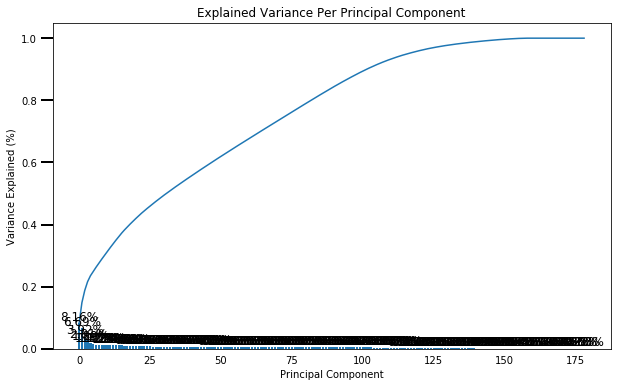

In [153]:
scree_plote_plote_plot(pca)

In [101]:
for n in range(100, 200):
    new_pca, new_X_pca = do_pca(n, X)
    print(f'{n} gives {new_pca.explained_variance_ratio_.sum()}')
    if new_pca.explained_variance_ratio_.sum() >= 0.90:
        break

100 gives 0.8879700696251007
101 gives 0.8926417135618774
102 gives 0.8970122899377018
103 gives 0.9020835371584736


In [154]:
# Make sure to use the decided upon number of components
# Variance should not be less that 60%
# https://www.researchgate.net/post/What_should_the_minumum_explained_variance_be_to_be_acceptable_in_factor_analysis
pca, X_pca = do_pca(103, X)

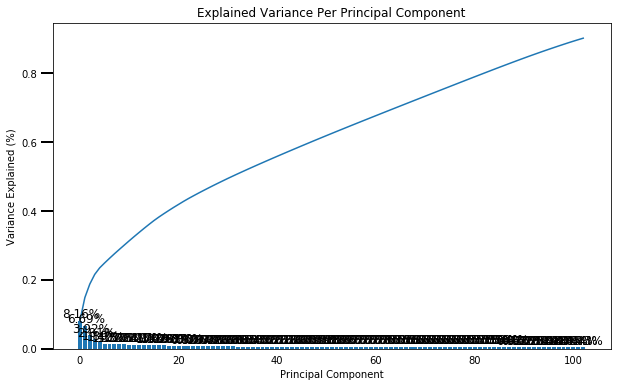

In [155]:
scree_plot(pca)

In [156]:
pca.explained_variance_ratio_.sum()

0.90214702945602609

In [157]:
len(pca.components_)

103

### Discussion 2.2: Perform Dimensionality Reduction

I decided to retain 90% of the variance. For that I need `103` principal components. That's a 41% reduction in the number of attributes. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). 

The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. 

If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. 

To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, **you should map each weight to their corresponding feature name, then sort the features according to weight**. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.

- **You should investigate and interpret feature associations from the first three principal components in this substep.** To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [132]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.



In [133]:
def pca_results(full_dataset, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

In [134]:
def get_pca_weights_for_ith(full_dataset, pca, i):
    """
    Returns a sorted Series containing the weight of each of the attributes
    in the full dataset, with respect to i'th Principal Component of the PCA
    
    `i` is zero-indexed
    """
    pca_result = pca_results(full_dataset, pca)
    # dropping the `Explained variance` column
    row_i = pca_result.iloc[i,1:]
    sort = row_i.sort_values()
    return sort

In [135]:
pca_weights = pca_results(low, pca)

In [136]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
dim0 = get_pca_weights_for_ith(low, pca, 0)
dim0

FINANZ_MINIMALIST                -0.2035
MOBI_REGIO                       -0.2009
KBA05_ANTG1                      -0.1886
PLZ8_ANTG1                       -0.1801
KBA05_GBZ                        -0.1772
PLZ8_GBZ                         -0.1332
KONSUMNAEHE                      -0.1311
INNENSTADT                       -0.1270
ALTERSKATEGORIE_GROB             -0.1220
FINANZ_VORSORGER                 -0.1217
LP_STATUS_FEIN_10.0              -0.1203
CAMEO_INTEL_2015_LIFE_STAGE      -0.1176
PRAEGENDE_JUGENDJAHRE_MOVEMENT   -0.1102
GREEN_AVANTGARDE                 -0.1102
LP_STATUS_FEIN_9.0               -0.1005
BALLRAUM                         -0.0966
ZABEOTYP_1                       -0.0944
FINANZTYP_2                      -0.0919
SEMIO_LUST                       -0.0903
GEBAEUDETYP_RASTER               -0.0903
CAMEO_DEUG_2015_2                -0.0847
SEMIO_ERL                        -0.0825
ANZ_PERSONEN                     -0.0825
WOHNDAUER_2008                   -0.0801
CAMEO_DEUG_2015_

In [137]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

dim1 = get_pca_weights_for_ith(low, pca, 1)
dim1

GEBURTSJAHR                    -0.2240
PRAEGENDE_JUGENDJAHRE_DECADE   -0.2186
ALTER_HH                       -0.2145
FINANZ_SPARER                  -0.1955
FINANZ_UNAUFFAELLIGER          -0.1936
SEMIO_REL                      -0.1852
FINANZ_ANLEGER                 -0.1847
SEMIO_PFLICHT                  -0.1794
SEMIO_TRADV                    -0.1753
ONLINE_AFFINITAET              -0.1657
SEMIO_RAT                      -0.1408
SEMIO_KULT                     -0.1401
SEMIO_FAM                      -0.1058
MOBI_REGIO                     -0.1035
PLZ8_ANTG1                     -0.1006
SEMIO_MAT                      -0.1002
KBA05_ANTG1                    -0.0981
KBA05_GBZ                      -0.0974
FINANZTYP_1                    -0.0969
ANZ_PERSONEN                   -0.0882
FINANZTYP_4                    -0.0855
FINANZTYP_3                    -0.0831
LP_STATUS_FEIN_5.0             -0.0824
ZABEOTYP_4                     -0.0820
ZABEOTYP_5                     -0.0761
PLZ8_GBZ                 

In [138]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
dim2 = get_pca_weights_for_ith(low, pca, 2)
dim2


ANREDE_KZ                        -0.3453
SEMIO_KAEM                       -0.3201
SEMIO_DOM                        -0.2867
SEMIO_KRIT                       -0.2632
SEMIO_ERL                        -0.2158
FINANZ_ANLEGER                   -0.1494
SEMIO_RAT                        -0.1439
SHOPPER_TYP_2.0                  -0.1105
FINANZTYP_1                      -0.1015
LP_STATUS_FEIN_2.0               -0.0931
ZABEOTYP_4                       -0.0738
FINANZ_HAUSBAUER                 -0.0685
SHOPPER_TYP_3.0                  -0.0629
LP_STATUS_FEIN_4.0               -0.0578
GEBURTSJAHR                      -0.0505
FINANZ_SPARER                    -0.0501
PRAEGENDE_JUGENDJAHRE_DECADE     -0.0485
ALTER_HH                         -0.0435
LP_FAMILIE_FEIN_4.0              -0.0420
FINANZ_UNAUFFAELLIGER            -0.0419
INNENSTADT                       -0.0405
ONLINE_AFFINITAET                -0.0403
KONSUMNAEHE                      -0.0367
ZABEOTYP_3                       -0.0354
BALLRAUM        

In [139]:
print(f'{dim0.nsmallest(2)} | {dim0.nlargest(2)}')

FINANZ_MINIMALIST   -0.2035
MOBI_REGIO          -0.2009
Name: Dimension 1, dtype: float64 | CAMEO_INTEL_2015_WEALTH    0.1813
HH_EINKOMMEN_SCORE         0.1795
Name: Dimension 1, dtype: float64


In [140]:
print(f'{dim1.nsmallest(2)} | {dim1.nlargest(2)}')

GEBURTSJAHR                    -0.2240
PRAEGENDE_JUGENDJAHRE_DECADE   -0.2186
Name: Dimension 2, dtype: float64 | ALTERSKATEGORIE_GROB    0.1985
FINANZ_VORSORGER        0.1903
Name: Dimension 2, dtype: float64


In [141]:
print(f'{dim2.nsmallest(2)} | {dim2.nlargest(2)}')

ANREDE_KZ    -0.3453
SEMIO_KAEM   -0.3201
Name: Dimension 3, dtype: float64 | SEMIO_VERT    0.3201
SEMIO_FAM     0.2711
Name: Dimension 3, dtype: float64


### Discussion 2.3: Interpret Principal Components

**The first component** is positivly influenced by attributes that has to do with income and wealth

**The second component** is negativly influenced by age, but strangly positivly influenced by `ALTERSKATEGORIE_GROB: Estimated age based on given name analysis`

**The third component** is negativly influenced by gender and "combative attitude" and positivlyt influenced by the affinity of "dreamful" and "family-minded".

One might be able to imagine a "type" of person, or a personality trait from these components. But you should be careful to generalize and read too much into it, I think.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [142]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

In [143]:
def plot_data(data, labels):
    plt.figure();
    plt.scatter(data[:, 0], data[:, 1], c=labels);



In [144]:
def plot_3d_data(data, labels):
    '''
    Plot data with colors associated with labels
    '''
    fig = plt.figure();
    ax = Axes3D(fig)
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap='tab10');

In [158]:
# Over a number of different cluster counts...

# run k-means clustering on the data and...
def do_kmeans(data ,n):
    kmeans = KMeans(n)
    model = kmeans.fit(data)
    labels = model.predict(data)
    score = np.abs(model.score(data))
    return {'labels': labels, 'score': score}

# compute the average within-cluster distances.
    
    

In [159]:
k3_dict = do_kmeans(X_pca, 3)

In [147]:
k3_dict['labels']

array([2, 0, 1, ..., 0, 1, 2], dtype=int32)

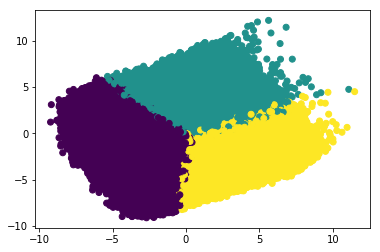

In [160]:
plot_data(X_pca, k3_dict['labels'])

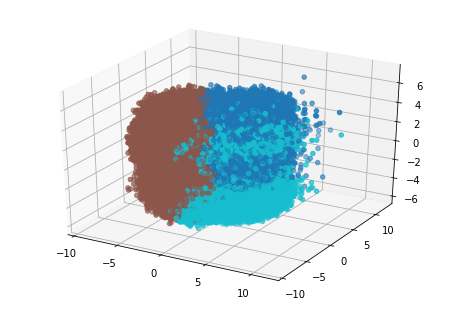

In [151]:
plot_3d_data(X_pca, k3_dict['labels'])

In [ ]:
k10_dict = do_kmeans(X_pca, 10)

In [ ]:
plot_data(X_pca, k10_dict['labels'])

In [ ]:
k5_dict = do_kmeans(X_pca, 5)

In [ ]:
plot_datadatadatadatadatadatadata_data(X_pca, k5_dict['labels'])

In [ ]:
plot_3d_data(X_pca, k5_dict['labels'])

In [ ]:
k20_dict = do_kmeans(X_pca, 20)

In [ ]:
plot_3d_data(X_pca, k20_dict['labels'])

In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
print(f"{k3_dict['score']}\n")
print(f"{k5_dict['score']}\n")
print(f"{k10_dict['score']}\n")
print(f"{k20_dict['score']}\n")


In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.



### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [ ]:
# Load in the customer demographics data.
customers = 

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.



### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.